In [2]:
import os
import copy
import tqdm
import pandas as pd
from datetime import datetime

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, datasets, models
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Check if Notebook runs in Colab
if 'COLAB_GPU' in os.environ:
    print("I'm running on Colab")
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = "/content/drive/MyDrive/GitHub/traffic-sign-classification/"
else: ROOT = "./"

DATA_PATH = ROOT + "data/gtsrb-german-traffic-sign/"

TRAIN_FILE = ROOT + "data/gtsrb-german-traffic-sign/Train.csv"
TEST_FILE = ROOT + "data/gtsrb-german-traffic-sign/Test.csv"

MODEL_CHECKPOINTS_PATH = ROOT + 'model_checkpoints/'
TENSORBOARD_PATH = ROOT + 'runs/'

if not os.path.exists(MODEL_CHECKPOINTS_PATH):
    os.makedirs(MODEL_CHECKPOINTS_PATH)
                
if not os.path.exists(TENSORBOARD_PATH):
    os.makedirs(TENSORBOARD_PATH)

I'm running on Colab
Mounted at /content/drive


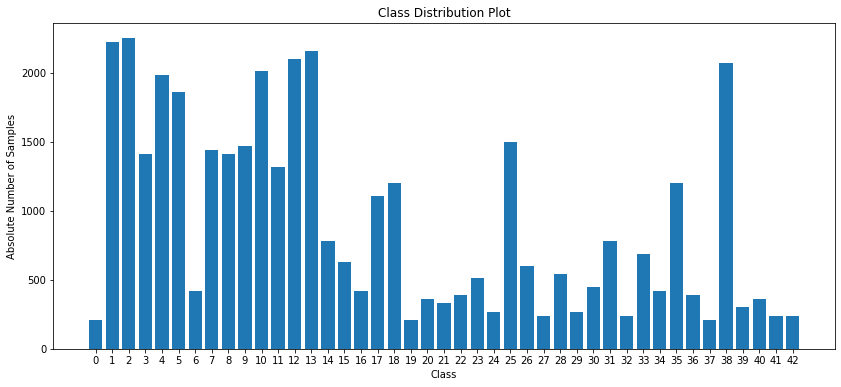

In [3]:
train = pd.read_csv(TRAIN_FILE).loc[:, ['ClassId', 'Path']]


data = train.loc[:, 'ClassId'].value_counts()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(data.index, data.values)
ax.set_title('Class Distribution Plot')
ax.set_xlabel('Class')
ax.set_ylabel('Absolute Number of Samples')
ax.set_xticks(data.index)
ax.set_xticklabels(data.index)
plt.show()

In [4]:
rotate_deg = 15
resize_image = 84
final_image_size = 64


transform_train = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.RandomRotation(rotate_deg),                      # Randomly rotate the image by up to 15 degrees
    # transforms.RandomHorizontalFlip(),                        # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2),                     # Randomly adjust brightness, contrast and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=3),       # Randomly ajust sharpness
    transforms.RandomPerspective(distortion_scale=.1, p=0.8),   # Rendomly changes the persective of the image
    transforms.RandomCrop((final_image_size, final_image_size)),# Randomly crop the image to 64x64
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2), 
    transforms.CenterCrop((final_image_size, final_image_size)),# Crop the center 64x64 portion of the image
    transforms.ToTensor(),
])

In [5]:
class DatasetGTSRB(Dataset):
    def __init__(self, root, df, transform=None):
        self.df = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        file_path = os.path.join(self.root, self.df.iloc[index, 1])
        label = self.df.iloc[index, 0]
        image = Image.open(file_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
batch_size = 256

df = pd.read_csv(TRAIN_FILE).loc[:, ['ClassId', 'Path']]
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True)

train_dataset = DatasetGTSRB(DATA_PATH, df_train, transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = DatasetGTSRB(DATA_PATH, df_val, transform=transform_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
class RestNet18(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT
        self.resnet18 = models.resnet18(weights=weights, progress=False)
        n_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(n_ftrs, 43)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet18(x)

model = RestNet18()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [8]:
def train_model(model, loader, optimizer, criterion, epoch, device, writer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Write the training loss and accuracy to TensorBoard
        iteration = epoch * len(loader) + i
        writer.add_scalar('Train/Loss', loss.item(), iteration)
        writer.add_scalar('Train/Accuracy', (predicted == labels).sum().item() / labels.size(0), iteration)

    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

In [9]:
def validate_model(model, loader, epoch, device, writer):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Write the validation loss and accuracy to TensorBoard
            iteration = epoch * len(loader) + i
            writer.add_scalar('Val/Loss', loss.item(), iteration)
            writer.add_scalar('Val/Accuracy', (predicted == labels).sum().item() / labels.size(0), iteration)

    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

In [10]:
class ModelCheckpoint:
    def __init__(self, file_path) -> None:
        self.file_path = file_path
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, optimizer, train_loss, val_loss) -> None:
        if self.best_loss == None:
            self.best_loss = val_loss
            self.save_model(model, optimizer)
        elif train_loss < val_loss:
            self.status = "train loss smaller than val loss"
        elif self.best_loss >= val_loss:
            self.best_loss = val_loss
            self.save_model(model, optimizer)
        else:
            self.status = "no improvements in val loss"

    def save_model(self, model, optimizer):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(self.file_path))
        self.status = f"Saved {self.file_path}"

In [11]:
# Unique identifier for the run
run = str(datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))                 

# Save path for tensorboard
writer_path = os.path.join(TENSORBOARD_PATH, f'{run}-tensorboard')
print('TensorBoard:', writer_path)

# Filename to save the model to
model_chckpoint_file = os.path.join(MODEL_CHECKPOINTS_PATH, f'{run}-model.pt')

# Init the tensorboard writer
writer = SummaryWriter(writer_path)

n_epochs = 30

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Define the criterion used while training
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Common range for weight decay 1e-4 and 1e-2
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Define the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Model checkpoints
model_chckpoint = ModelCheckpoint(model_chckpoint_file)

model.to(device)    # Load the model to the device
for epoch in range(n_epochs):

    train_loss, train_acc = train_model(model, train_dataloader, optimizer,
                                        criterion, epoch, device, writer)
    
    val_loss, val_acc = validate_model(model, val_dataloader, epoch, device, writer)
    
    # scheduler.step()  # Reduce learning rate every epoch
    
    # Save best model
    model_chckpoint(model, optimizer, train_loss, val_loss)
    
    # Plot the epoch results
    print(f'Epoch [{epoch+1}/{n_epochs}] | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Checkpoint status: {model_chckpoint.status}')

writer.flush()

TensorBoard: /content/drive/MyDrive/GitHub/traffic-sign-classification/runs/2023-03-09_17:00:02-tensorboard
Using device:  cuda:0
Epoch [1/30] | Train Loss: 1.0850 | Val Loss: 0.1261 | Train Acc: 0.7092 | Val Acc: 0.9708 | Checkpoint status: Saved /content/drive/MyDrive/GitHub/traffic-sign-classification/model_checkpoints/2023-03-09_17:00:02-model.pt
Epoch [2/30] | Train Loss: 0.0977 | Val Loss: 0.0253 | Train Acc: 0.9741 | Val Acc: 0.9948 | Checkpoint status: Saved /content/drive/MyDrive/GitHub/traffic-sign-classification/model_checkpoints/2023-03-09_17:00:02-model.pt
Epoch [3/30] | Train Loss: 0.0392 | Val Loss: 0.0141 | Train Acc: 0.9895 | Val Acc: 0.9971 | Checkpoint status: Saved /content/drive/MyDrive/GitHub/traffic-sign-classification/model_checkpoints/2023-03-09_17:00:02-model.pt
Epoch [4/30] | Train Loss: 0.0228 | Val Loss: 0.0124 | Train Acc: 0.9944 | Val Acc: 0.9971 | Checkpoint status: Saved /content/drive/MyDrive/GitHub/traffic-sign-classification/model_checkpoints/2023-03

In [12]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    acc = correct / total

    print(f'Test Loss: {loss:.4f} | Test Acc: {100 * acc:.2f}%')

In [13]:
# Load test dataset
df_test = pd.read_csv(TEST_FILE).loc[:, ['ClassId', 'Path']]

test_dataset = DatasetGTSRB(DATA_PATH, df_test, transform=transform_val)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

# Loading a saved model
checkpoint = torch.load(model_chckpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Evaluate the model
evaluate_model(model, test_dataloader, criterion, device)

Using device:  cuda:0
Test Loss: 0.0583 | Test Acc: 98.61%
